![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 6 - Convolutional Neural Network</center>
### <center> 2D CNN - Solution</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/MainCnn2D_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/06_CNN/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [5]:
#-- Record figures during training:
from DeepLearningFramework.Training import TrainClassficationModel

### Exercise
* Load the Fashion-MNIST dataset.
* Use 2D CNN, try to get the high accuracy (above 92% is good).

#### Download Fashion-MNIST dataset:

In [6]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

torch.Size([60000, 28, 28])

In [7]:
lClasses  = oTrainSet.classes
lClasses

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

#### Plot some examples:

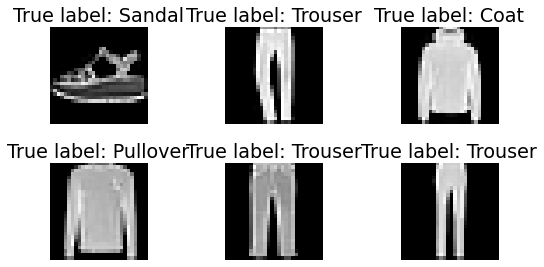

In [8]:
N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow   (mX.squeeze(), cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    ax.axis     (False)
    
plt.tight_layout()
plt.show        ()

#### Compute mean and variance:

In [9]:
mean = oTrainSet.data.float().mean() / 255
std  = oTrainSet.data.float().std () / 255
print('µ =', mean)
print('σ =', std)

µ = tensor(0.2860)
σ = tensor(0.3530)


#### Set datasets with normalization:

In [10]:
oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(mean, std)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [11]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY       = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

#### Define the model (2D CNN):

In [12]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchinfo
    
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(1,   16,  3, bias=False),           nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(16,  32,  3, bias=False),           nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(64,  128, 3, bias=False),           nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(128, 256, 3, bias=False, stride=2), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.1),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (256, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [256, 1, 28, 28]          --
├─Conv2d: 1-2                            [256, 16, 26, 26]         144
├─BatchNorm2d: 1-3                       [256, 16, 26, 26]         32
├─ReLU: 1-4                              [256, 16, 26, 26]         --
├─Dropout2d: 1-5                         [256, 16, 26, 26]         --
├─Conv2d: 1-6                            [256, 32, 24, 24]         4,608
├─BatchNorm2d: 1-7                       [256, 32, 24, 24]         64
├─ReLU: 1-8                              [256, 32, 24, 24]         --
├─Dropout2d: 1-9                         [256, 32, 24, 24]         --
├─Conv2d: 1-10                           [256, 64, 11, 11]         18,432
├─BatchNorm2d: 1-11                      [256, 64, 11, 11]         128
├─ReLU: 1-12                             [256, 64, 11, 11]         --
├─Drop

#### Check whether GPU is available:

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

#### Train the model:

In [14]:
Loss    = nn.CrossEntropyLoss()
nEpochs = 30

oModel   = GetModel               ().to(DEVICE)
oOptim   = optim.AdamW            (oModel.parameters(), lr=3e-3, betas=(0.9, 0.99), weight_decay=1e-3)
lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)

Epoch 000: | Train loss:  0.621 | Val loss:  0.416 | Train Accuracy:  0.773 | Val Accuracy:  0.851 | epoch time:  4.504 | <-- Checkpoint!
Epoch 001: | Train loss:  0.383 | Val loss:  0.321 | Train Accuracy:  0.862 | Val Accuracy:  0.883 | epoch time:  3.033 | <-- Checkpoint!
Epoch 002: | Train loss:  0.320 | Val loss:  0.310 | Train Accuracy:  0.884 | Val Accuracy:  0.890 | epoch time:  2.861 | <-- Checkpoint!
Epoch 003: | Train loss:  0.290 | Val loss:  0.282 | Train Accuracy:  0.895 | Val Accuracy:  0.894 | epoch time:  2.798 | <-- Checkpoint!
Epoch 004: | Train loss:  0.268 | Val loss:  0.272 | Train Accuracy:  0.902 | Val Accuracy:  0.901 | epoch time:  2.830 | <-- Checkpoint!
Epoch 005: | Train loss:  0.252 | Val loss:  0.252 | Train Accuracy:  0.909 | Val Accuracy:  0.909 | epoch time:  2.773 | <-- Checkpoint!
Epoch 006: | Train loss:  0.236 | Val loss:  0.243 | Train Accuracy:  0.915 | Val Accuracy:  0.910 | epoch time:  2.788 | <-- Checkpoint!
Epoch 007: | Train loss:  0.223 | 

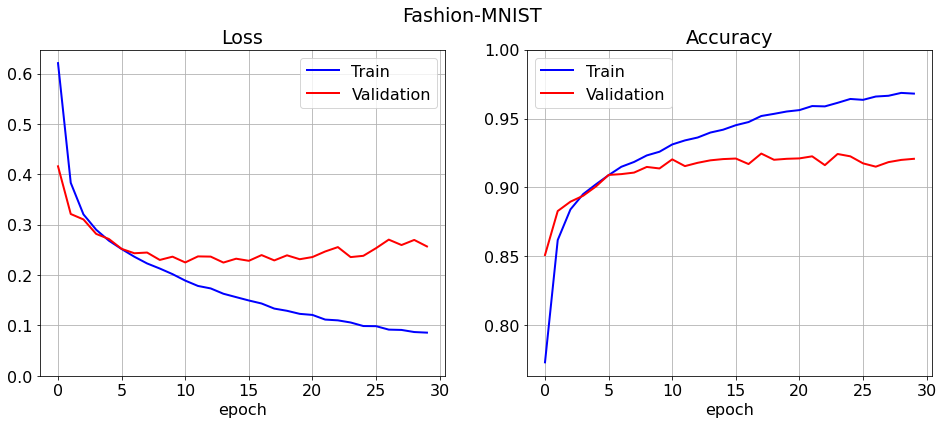

In [15]:
from DeepLearningFramework.Utils import PlotHistory

PlotHistory (lHistory)
plt.suptitle('Fashion-MNIST')
plt.show    ()